<a href="https://colab.research.google.com/github/shoubhikchakraborty/DeepFashion_Try_On/blob/master/flickr8k_image_caption.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import zipfile
import os
import time
import seaborn as sns
import string
import spacy
import numpy as np
import pandas as pd
from PIL import Image
from matplotlib import pyplot as plt
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader
from torchvision import transforms, models
from torch.nn.utils.rnn import pad_sequence
from torch.nn.utils.rnn import pack_padded_sequence
from tqdm import tqdm_notebook

In [ ]:
#checking whether gpu is available
if torch.cuda.is_available():
  device = torch.device('cuda')
  print(torch.cuda.get_device_properties(0))
else:
  device = torch.device('cpu')
  print(device)

cpu


In [ ]:
# Uploading the kaggle.json file
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"shoubhikc","key":"f2a17e24a39a0f133d660c9fe10a19a5"}'}

In [ ]:
# placing kaggle.json in kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

# Loading Data

In [ ]:
! kaggle datasets download -d adityajn105/flickr8k

 99% 1.03G/1.04G [00:09<00:00, 92.1MB/s]
100% 1.04G/1.04G [00:09<00:00, 114MB/s] 


In [ ]:
# unzipping the data
import zipfile
zip_ref = zipfile.ZipFile("/content/flickr8k.zip", 'r')
zip_ref.extractall("/content/flicker8k")
zip_ref.close()

In [ ]:
df = pd.read_csv('/content/flicker8k/captions.txt')

In [ ]:
df.head()

image                                            caption
0  1000268201_693b08cb0e.jpg  A child in a pink dress is climbing up a set o...
1  1000268201_693b08cb0e.jpg              A girl going into a wooden building .
2  1000268201_693b08cb0e.jpg   A little girl climbing into a wooden playhouse .
3  1000268201_693b08cb0e.jpg  A little girl climbing the stairs to her playh...
4  1000268201_693b08cb0e.jpg  A little girl in a pink dress going into a woo...

In [ ]:
df.image.nunique()

8091

In [ ]:
df.shape

(40455, 2)

In [ ]:
img_dir = '/content/flicker8k/Images'

A black dog and a tri-colored dog playing with each other on the road .


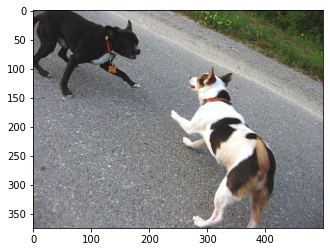

In [ ]:
idx = 6
filepath = img_dir + '/' +df.iloc[idx]['image']
image = Image.open(filepath)
plt.imshow(image)
print(df.iloc[idx]['caption'])

# Creating vocabulary for the data

In [ ]:
# loading the english corpus
spacy_eng = spacy.load("en")

In [ ]:
class Vocabulary:
    def __init__(self, freq_threshold):
        self.itos = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}
        self.stoi = {"<PAD>": 0, "<SOS>": 1, "<EOS>": 2, "<UNK>": 3}
        self.freq_threshold = freq_threshold

    def __len__(self):
        return len(self.itos)

    @staticmethod
    def tokenizer_eng(text):
        return [tok.text.lower() for tok in spacy_eng.tokenizer(text)]

    def build_vocabulary(self, sentence_list):
        frequencies = {}
        idx = 4

        for sentence in sentence_list:
            for word in self.tokenizer_eng(sentence):
                if word not in frequencies:
                    frequencies[word] = 1

                else:
                    frequencies[word] += 1

                if frequencies[word] == self.freq_threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1

    def numericalize(self, text):
        tokenized_text = self.tokenizer_eng(text)

        return [
            self.stoi[token] if token in self.stoi else self.stoi["<UNK>"]
            for token in tokenized_text
        ]

# Dataset and Dataloader

In [ ]:
class CaptionDataset(Dataset):
  def __init__(self, img_dir, caption, transform = None, threshold = 1):
    self.img_dir = img_dir
    self.df = pd.read_csv(caption)
    self.transform = transform
    self.vocab = Vocabulary(threshold)
    self.vocab.build_vocabulary(self.df['caption'].tolist())

  def __len__(self):
    return self.df.shape[0]

  def __getitem__(self, idx):
    filename = self.img_dir + "/" +self.df.iloc[idx]['image']
    img = Image.open(filename)
    if self.transform is not None:
      img = self.transform(img)
    else:
      trans = transforms.ToTensor()
      img = trans(img)

    captions = [self.vocab.stoi['<SOS>']]
    captions += self.vocab.numericalize(self.df.iloc[idx]['caption'])
    captions += [self.vocab.stoi['<EOS>']]

    return img, torch.tensor(captions)



In [ ]:
transform = transforms.Compose(
        [
            transforms.Resize((299, 299)),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225)),
        ]
    )

In [ ]:
dataset = CaptionDataset(img_dir = img_dir, caption = '/content/flicker8k/captions.txt', transform= transform)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Token: tensor([  1,  51, 452, 453, 260,  43,   4, 454, 455,   4, 456,  18,   2])
Sentence:
['<SOS>', 'two', 'constructions', 'workers', 'sit', 'on', 'a', 'beam', 'taking', 'a', 'break', '.', '<EOS>']


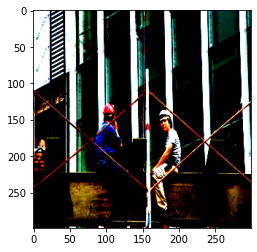

In [ ]:
img, caps = dataset[200]
plt.imshow(img.permute(1,2,0))
print("Token:",caps)
print("Sentence:")
print([dataset.vocab.itos[token] for token in caps.tolist()])

In [ ]:
train_len = int(0.80 * len(dataset))
valid_len  = int(len(dataset) - (train_len))
train_set, val_set = torch.utils.data.random_split (dataset, lengths= [train_len, valid_len])

Collate function is used so that the sequence lengths for all the text input remain same. 

In [ ]:
def collate_fn(data):
    data.sort(key=lambda  x: len(x[1]), reverse=True)
    images, captions = zip(*data)

    images = torch.stack(images, 0)

    lengths = [len(cap) for cap in captions]
    targets = torch.zeros(len(captions), max(lengths)).long()
    for i, cap in enumerate(captions):
        end = lengths[i]
        targets[i, :end] = cap[:end]
    return images, targets

In [ ]:
train_dataloader = DataLoader(train_set, batch_size= 64, collate_fn=collate_fn)
test_dataloader = DataLoader(val_set, batch_size= 32, collate_fn=collate_fn)

In [ ]:
def show_image(img, title=None):
    """Imshow for Tensor."""
    
    #unnormalize 
    img[0] = img[0] * 0.229
    img[1] = img[1] * 0.224 
    img[2] = img[2] * 0.225 
    img[0] += 0.485 
    img[1] += 0.456 
    img[2] += 0.406
    
    img = img.numpy().transpose((1, 2, 0))
    
    
    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

['<SOS>', 'there', 'is', 'a', 'shirtless', 'man', 'leaning', 'against', 'a', 'wall', 'and', 'a', 'woman', 'in', 'a', 'red', 'shirt', 'with', 'her', 'back', 'to', 'him', '.', '<EOS>']


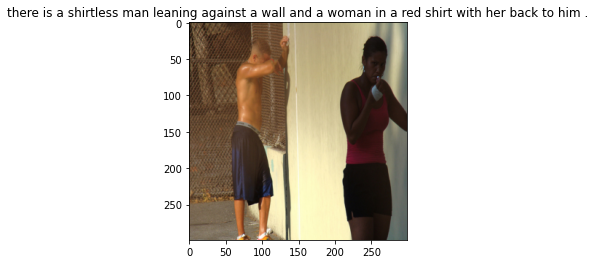

['<SOS>', 'three', 'naked', 'little', 'boys', 'are', 'playing', 'in', 'a', 'river', 'and', 'are', 'covered', 'in', 'mud', ';', 'one', 'is', 'standing', 'up', '.', '<EOS>', '<PAD>', '<PAD>']


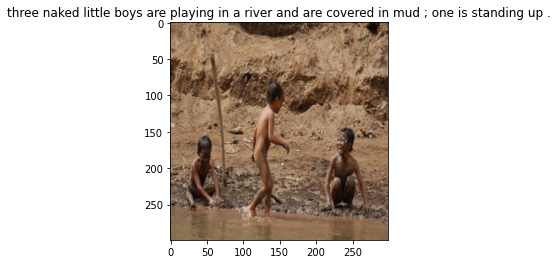

['<SOS>', 'a', 'man', 'in', 'a', 'blue', 'shirt', ',', 'black', 'jacket', ',', 'and', 'glasses', 'smiling', 'with', 'his', 'arms', 'crossed', '.', '<EOS>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']


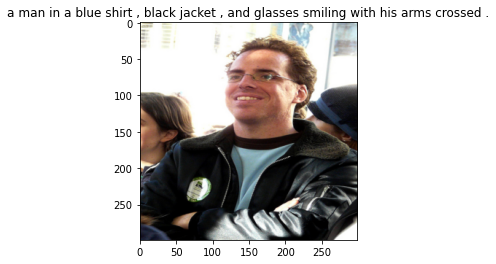

['<SOS>', 'kids', 'are', 'playing', 'on', 'a', 'swing', 'set', 'as', 'a', 'man', 'with', 'no', 'shirt', 'on', 'walks', 'by', '.', '<EOS>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']


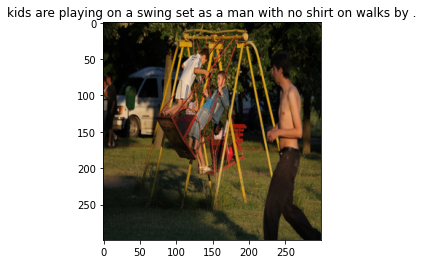

['<SOS>', 'a', 'man', 'in', 'flag', 'underwear', 'standing', 'on', 'the', 'steps', 'with', 'a', 'book', 'and', 'black', 'shoes', 'on', '.', '<EOS>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']


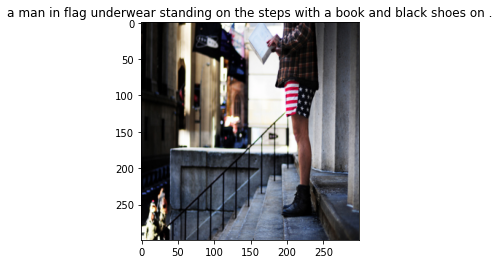

['<SOS>', 'a', 'rather', 'large', 'blonde', 'dog', 'with', 'a', 'black', 'collar', 'chases', 'a', 'blue', 'and', 'yellow', 'toy', '.', '<EOS>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']


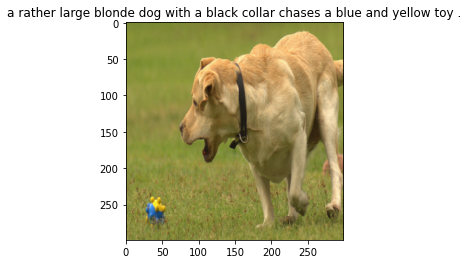

['<SOS>', 'a', 'person', 'in', 'a', 'red', 'and', 'black', 'outfit', 'climbing', 'the', 'side', 'of', 'an', 'icy', 'mountain', ',', '<EOS>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']


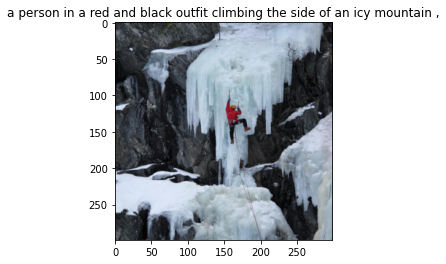

['<SOS>', 'a', 'boy', 'rides', 'his', 'red', 'bicycle', 'down', 'the', 'handrail', 'of', 'a', 'staircase', 'in', 'a', 'city', '.', '<EOS>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']


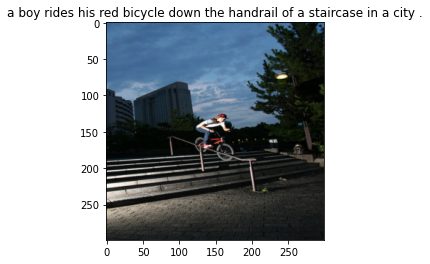

['<SOS>', 'a', 'boy', 'in', 'a', 'redskins', 'jersey', 'jumps', 'up', 'to', 'scare', 'a', 'patch', 'of', 'pumpkins', '.', '<EOS>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']


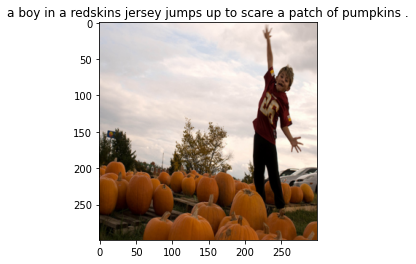

['<SOS>', 'a', 'group', 'of', 'people', 'are', 'standing', 'on', 'a', 'beach', 'near', 'to', 'a', 'white', 'sunshade', '.', '<EOS>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']


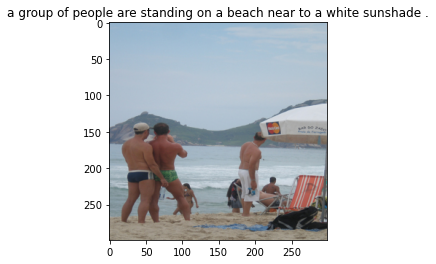

['<SOS>', 'a', 'young', 'woman', 'touching', 'a', 'young', 'man', "'s", 'cheek', 'while', 'a', 'friend', 'looks', 'on', '<EOS>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']


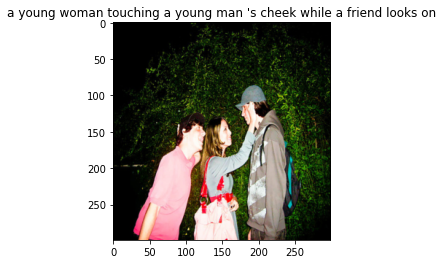

['<SOS>', 'a', 'swimmer', 'wearing', 'a', 'black', 'hat', 'and', 'goggles', 'is', 'doing', 'the', 'butterfly', 'stroke', '.', '<EOS>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']


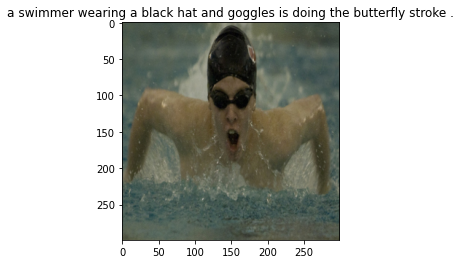

['<SOS>', 'the', 'man', 'and', 'woman', 'are', 'wearing', 'kimonos', 'and', 'are', 'standing', 'in', 'a', 'store', '.', '<EOS>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']


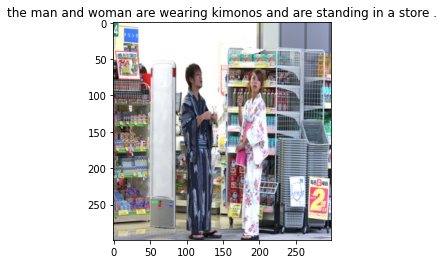

['<SOS>', 'an', 'older', 'man', 'in', 'a', 'weathered', 'fedora', 'smiles', 'slightly', 'for', 'the', 'camera', '.', '<EOS>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']


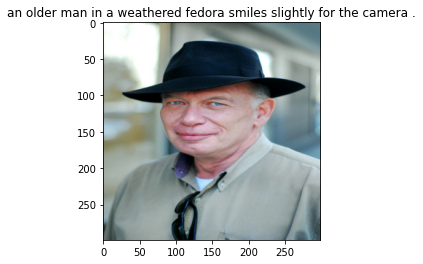

['<SOS>', 'the', 'large', 'brown', 'dog', 'with', 'the', 'red', 'collar', 'is', 'in', 'the', 'grass', '.', '<EOS>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']


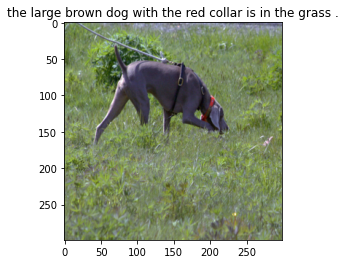

['<SOS>', 'a', 'man', 'talks', 'on', 'his', 'cellphone', 'as', 'he', 'walks', 'down', 'the', 'street', '.', '<EOS>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']


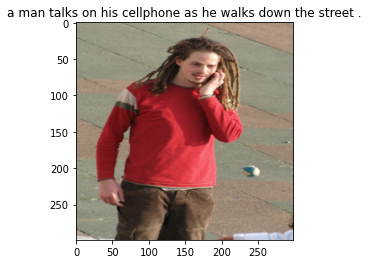

In [ ]:
dataiter = iter(train_dataloader)

#getting the next batch
batch = next(dataiter)

#unpacking the batch
images, captions = batch
#showing info of image in single batch
for i in range(16):
    img,cap = images[i],captions[i]
    caption_label = [dataset.vocab.itos[token] for token in cap.tolist()]
    print(caption_label)
    eos_index = caption_label.index('<EOS>')
    caption_label = caption_label[1:eos_index]
    caption_label = ' '.join(caption_label)                      
    show_image(img,caption_label)
    plt.show()

# Building Model

In [ ]:
resnet = models.resnet50(pretrained= True)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


**ENCODER**

We use a convolutional neural network in order to extract a
set of feature vectors. In order to obtain a correspondence between the feature
vectors and portions of the 2-D image, we extract features
from a lower convolutional layer instead of using a fully connected layer. This allows the
decoder to selectively focus on certain parts of an image by
weighting a subset of all the feature vectors.

In [ ]:
class EncoderCNN(nn.Module):
  def __init__(self):
    super(EncoderCNN, self).__init__()
    resnet = models.resnet50(pretrained= True)
    for params in resnet.parameters():
      params.requires_grad_(False)
    layers = list(resnet.children())[:-2]
    self.resnet = nn.Sequential(*layers)

  def forward(self, img):
    img = self.resnet(img)  # shape = [batch_size, 2048, 10, 10]
    img = img.permute(0,2,3,1)
    img = img.view(img.size(0), -1, img.size(-1))   # shape = [batch_size, 100, 2048]
    return img


**ATTENTION**

We are using Bahdanau attention to focus on a certain portion of the image.

In [ ]:
class Attention(nn.Module):
  def __init__(self, encoder_dim, decoder_dim, attention_dim):
    super(Attention, self).__init__()
    
    self.W = nn.Linear(decoder_dim, attention_dim)
    self.U = nn.Linear(encoder_dim, attention_dim)
    self.A = nn.Linear(attention_dim, 1)

  def forward(self, features, hidden_state):
    u_hs = self.U(features) #shape = [batch_size, num_layers, attention_dim]
    w_ah = self.W(hidden_state)  #shape = [batch_size, attention_dim]
    combined_states = torch.tanh(u_hs + w_ah.unsqueeze(1))  #shape = [batch_size, num_layers, attention_dim]
    attention_score = self.A(combined_states) #shape = [batch_size, num_layers, 1]
    attention_score = attention_score.squeeze(2)   #shape = [batch_size, num_layers]
    alpha = F.softmax(attention_score, dim =1) #shape = [batch_size, num_layers]
    attention_weights = features*alpha.unsqueeze(2)   #shape = [batch_size, num_layers, features_dim]
    attention_weights = attention_weights.sum(dim = 1)   #shape = [batch_size, num_layers]

    return alpha, attention_weights


**Decoder**

We use a long short-term memory (LSTM) network that produces a
caption by generating one word at every time step conditioned on a context vector, the previous hidden state and the
previously generated words. 

In [ ]:
class DecoderRNN(nn.Module):
    def __init__(self,embed_size, vocab_size, attention_dim,encoder_dim,decoder_dim,drop_prob=0.3):
        super().__init__()
        
        #save the model param
        self.vocab_size = vocab_size
        self.attention_dim = attention_dim
        self.decoder_dim = decoder_dim
        
        self.embedding = nn.Embedding(vocab_size,embed_size)
        self.attention = Attention(encoder_dim,decoder_dim,attention_dim)
        
        
        self.init_h = nn.Linear(encoder_dim, decoder_dim)  
        self.init_c = nn.Linear(encoder_dim, decoder_dim)  
        self.lstm_cell = nn.LSTMCell(embed_size+encoder_dim,decoder_dim,bias=True)
        self.f_beta = nn.Linear(decoder_dim, encoder_dim)
        
        
        self.fcn = nn.Linear(decoder_dim,vocab_size)
        self.drop = nn.Dropout(drop_prob)
        
        
    
    def forward(self, features, captions):
        
        #vectorize the caption
        embeds = self.embedding(captions)
        
        # Initialize LSTM state
        h, c = self.init_hidden_state(features)  # (batch_size, decoder_dim)
        
        #get the seq length to iterate
        seq_length = len(captions[0])-1 #Exclude the last one
        batch_size = captions.size(0)
        num_features = features.size(1)
        
        preds = torch.zeros(batch_size, seq_length, self.vocab_size).to(device)
        alphas = torch.zeros(batch_size, seq_length,num_features).to(device)
                
        for s in range(seq_length):
            alpha,context = self.attention(features, h)
            lstm_input = torch.cat((embeds[:, s], context), dim=1)
            h, c = self.lstm_cell(lstm_input, (h, c))
                    
            output = self.fcn(self.drop(h))
            
            preds[:,s] = output
            alphas[:,s] = alpha  
        
        
        return preds, alphas
    
    def generate_caption(self,features,max_len=20,vocab=None):
        # Inference part
        # Given the image features generate the captions
        
        batch_size = features.size(0)
        h, c = self.init_hidden_state(features)  # (batch_size, decoder_dim)
        
        alphas = []
        
        #starting input
        word = torch.tensor(vocab.stoi['<SOS>']).view(1,-1).to(device)
        embeds = self.embedding(word)

        
        captions = []
        
        for i in range(max_len):
            alpha,context = self.attention(features, h)
            
            
            #store the alpha score
            alphas.append(alpha.cpu().detach().numpy())
            
            lstm_input = torch.cat((embeds[:, 0], context), dim=1)
            h, c = self.lstm_cell(lstm_input, (h, c))
            output = self.fcn(self.drop(h))
            output = output.view(batch_size,-1)
        
            
            #select the word with most val
            predicted_word_idx = output.argmax(dim=1)
            
            #save the generated word
            captions.append(predicted_word_idx.item())
            
            #end if <EOS detected>
            if vocab.itos[predicted_word_idx.item()] == "<EOS>":
                break
            
            #send generated word as the next caption
            embeds = self.embedding(predicted_word_idx.unsqueeze(0))
        
        #covert the vocab idx to words and return sentence
        return [vocab.itos[idx] for idx in captions],alphas
    
    
    def init_hidden_state(self, encoder_out):
        mean_encoder_out = encoder_out.mean(dim=1)
        h = self.init_h(mean_encoder_out)  # (batch_size, decoder_dim)
        c = self.init_c(mean_encoder_out)
        return h, c

**SHOW ATTEND AND TELL**

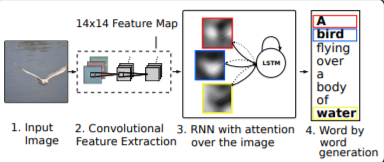

In [ ]:
class EncoderDecoder(nn.Module):
    def __init__(self,embed_size, vocab_size, attention_dim,encoder_dim,decoder_dim,drop_prob=0.3):
        super().__init__()
        self.encoder = EncoderCNN()
        self.decoder = DecoderRNN(
            embed_size=embed_size,
            vocab_size = len(dataset.vocab),
            attention_dim=attention_dim,
            encoder_dim=encoder_dim,
            decoder_dim=decoder_dim
        )
        
    def forward(self, images, captions):
        features = self.encoder(images)
        outputs = self.decoder(features, captions)
        return outputs

In [ ]:
embed_size=300
vocab_size = len(dataset.vocab)
attention_dim=256
encoder_dim=2048
decoder_dim=512
learning_rate = 3e-4

In [ ]:
model = EncoderDecoder(
    embed_size=300,
    vocab_size = len(dataset.vocab),
    attention_dim=256,
    encoder_dim=2048,
    decoder_dim=512
).to(device)

# Model Training

In [ ]:
criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi["<PAD>"]) # ignoring the padding in the sequence
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
def show_image(img, title=None):
    """Imshow for Tensor."""
    
    #unnormalize 
    img[0] = img[0] * 0.229
    img[1] = img[1] * 0.224 
    img[2] = img[2] * 0.225 
    img[0] += 0.485 
    img[1] += 0.456 
    img[2] += 0.406
    
    img = img.numpy().transpose((1, 2, 0))
    
    
    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

epoch : 1
Epoch: 1 loss: 2.30586
Epoch: 1 loss: 2.44701
Epoch: 1 loss: 2.25032
Epoch: 1 loss: 2.24212
Epoch: 1 loss: 2.20868
time taken for epoch 1 : 579.802943944931, total loss : 2.295766843637459


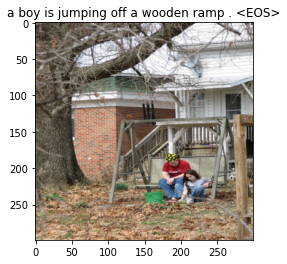

epoch : 2
Epoch: 2 loss: 2.30622
Epoch: 2 loss: 2.43582
Epoch: 2 loss: 2.28974
Epoch: 2 loss: 2.24896
Epoch: 2 loss: 2.16280
time taken for epoch 2 : 583.0520424842834, total loss : 2.297185642681574


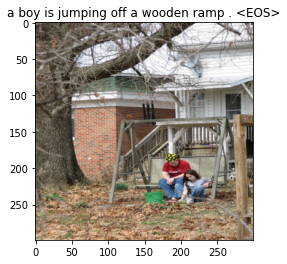

epoch : 3
Epoch: 3 loss: 2.27081
Epoch: 3 loss: 2.42840
Epoch: 3 loss: 2.28540
Epoch: 3 loss: 2.23421
Epoch: 3 loss: 2.16960
time taken for epoch 3 : 580.3143146038055, total loss : 2.295645070641408


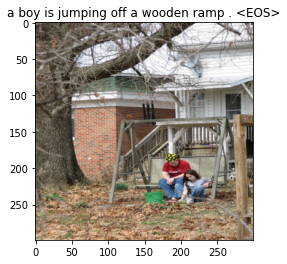

epoch : 4
Epoch: 4 loss: 2.29716
Epoch: 4 loss: 2.43665
Epoch: 4 loss: 2.29919
Epoch: 4 loss: 2.23855
Epoch: 4 loss: 2.17954
time taken for epoch 4 : 582.2228388786316, total loss : 2.296467623691785


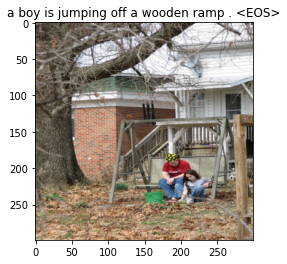

epoch : 5
Epoch: 5 loss: 2.26878
Epoch: 5 loss: 2.44935
Epoch: 5 loss: 2.27025
Epoch: 5 loss: 2.25955
Epoch: 5 loss: 2.17808
time taken for epoch 5 : 583.5220580101013, total loss : 2.2965820111304875


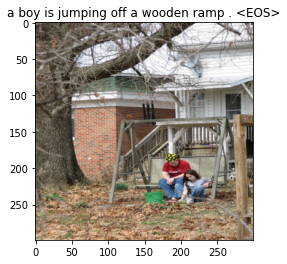

epoch : 6
Epoch: 6 loss: 2.30794
Epoch: 6 loss: 2.44257
Epoch: 6 loss: 2.27928
Epoch: 6 loss: 2.23882
Epoch: 6 loss: 2.16021
time taken for epoch 6 : 585.2955324649811, total loss : 2.2945999474864704


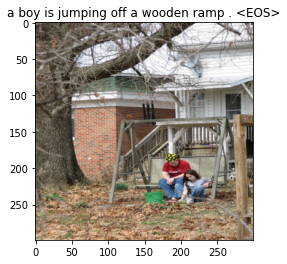

epoch : 7
Epoch: 7 loss: 2.29049
Epoch: 7 loss: 2.44643
Epoch: 7 loss: 2.27675
Epoch: 7 loss: 2.25999
Epoch: 7 loss: 2.17631
time taken for epoch 7 : 581.3893527984619, total loss : 2.2959042935974514


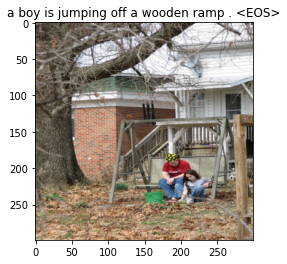

epoch : 8
Epoch: 8 loss: 2.30246
Epoch: 8 loss: 2.42923
Epoch: 8 loss: 2.27116
Epoch: 8 loss: 2.20541
Epoch: 8 loss: 2.17642
time taken for epoch 8 : 573.830230474472, total loss : 2.295900492800083


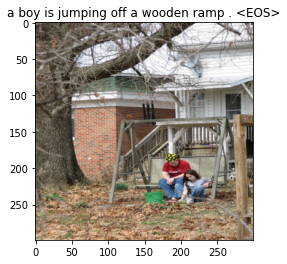

epoch : 9
Epoch: 9 loss: 2.28559
Epoch: 9 loss: 2.43658
Epoch: 9 loss: 2.26232
Epoch: 9 loss: 2.21648
Epoch: 9 loss: 2.16107
time taken for epoch 9 : 573.4862017631531, total loss : 2.296273412676197


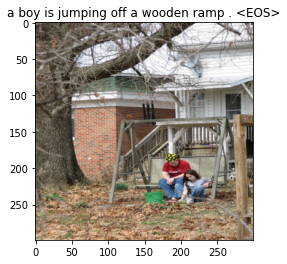

epoch : 10
Epoch: 10 loss: 2.30443
Epoch: 10 loss: 2.44119
Epoch: 10 loss: 2.28360
Epoch: 10 loss: 2.24664
Epoch: 10 loss: 2.17558
time taken for epoch 10 : 575.363454580307, total loss : 2.296463609448535


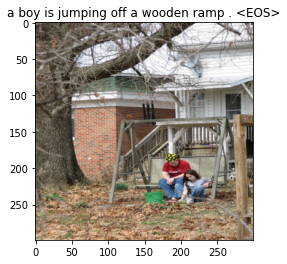

In [ ]:
import time
num_epochs = 10
print_every = 100
best_loss = np.nan
for epoch in range(1,num_epochs+1):
    print(f"epoch : {epoch}")
    start = time.time() 
    final_loss = 0 
    for idx, (image, captions) in enumerate(iter(train_dataloader)):
        model.train()
        image,captions = image.to(device),captions.to(device)

        # Zero the gradients.
        optimizer.zero_grad()

        # Feed forward
        outputs,attentions = model(image, captions)

        # Calculate the batch loss.
        targets = captions[:,1:]
        loss = criterion(outputs.view(-1, vocab_size), targets.reshape(-1))
        
        # Backward pass.
        loss.backward()

        # Update the parameters in the optimizer.
        optimizer.step()
        final_loss += loss.item()
        if (idx+1)%print_every == 0:
            print("Epoch: {} loss: {:.5f}".format(epoch,loss.item()))
    print(f"time taken for epoch {epoch} : {time.time() - start}, total loss : {final_loss/len(train_dataloader)}") 
            
    #generate the caption
    model.eval()
    with torch.no_grad():
          dataiter = iter(test_dataloader)
          img,_ = next(dataiter)
          features = model.encoder(img[0:1].to(device))
          caps,alphas = model.decoder.generate_caption(features,vocab=dataset.vocab)
          
          
          caption = ' '.join(caps)  
          show_image(img[0],title=caption)     
      
        
    #save the latest model
    if final_loss < best_loss:
        torch.save(model.state_dict(), "/content/drive/MyDrive/Colab Notebooks/image_caption.pt")
        best_loss = final_loss
    #save_model(model,epoch)

In [ ]:
model_save_name = 'image_caption.pt'
path = f"/content/drive/MyDrive/Colab Notebooks/{model_save_name}" 
#torch.save(model.state_dict(), path)

In [ ]:
device = torch.device('cpu')

In [ ]:
model.load_state_dict(torch.load(path, map_location=lambda storage, loc: storage))

<All keys matched successfully>

In [ ]:
#generate caption
def get_caps_from(features_tensors):
    #generate the caption
    model.eval()
    with torch.no_grad():
        features = model.encoder(features_tensors.to(device))
        caps,alphas = model.decoder.generate_caption(features,vocab=dataset.vocab)
        caption = ' '.join(caps)
        show_image(features_tensors[0],title=caption)
    
    return caps,alphas

#Show attention
def plot_attention(img, result, attention_plot):
    #untransform
    img[0] = img[0] * 0.229
    img[1] = img[1] * 0.224 
    img[2] = img[2] * 0.225 
    img[0] += 0.485 
    img[1] += 0.456 
    img[2] += 0.406
    
    img = img.numpy().transpose((1, 2, 0))
    temp_image = img

    fig = plt.figure(figsize=(15, 15))

    len_result = len(result)
    for l in range(len_result):
        temp_att = attention_plot[l].reshape(10,10)
        
        ax = fig.add_subplot(len_result//2,len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.7, extent=img.get_extent())
        

    plt.tight_layout()
    plt.show()

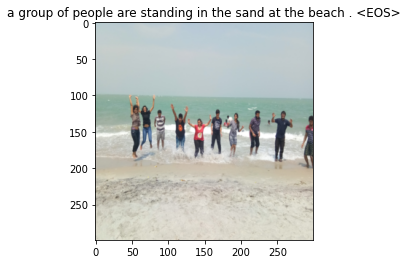

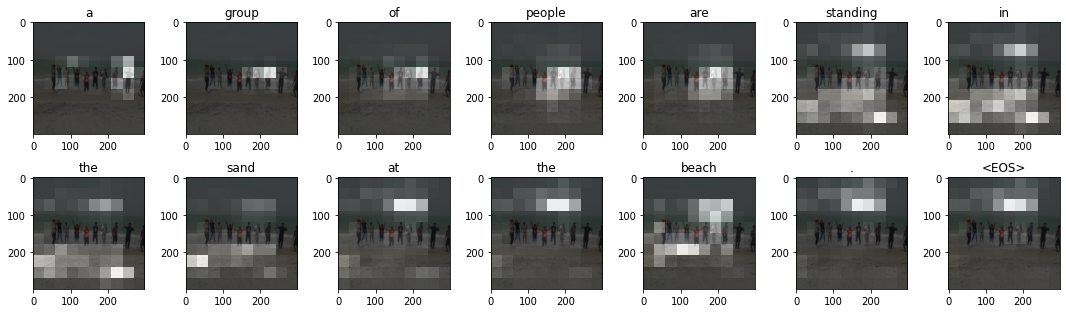

In [ ]:
img = Image.open('/content/drive/MyDrive/IMG_20180310_131506 (1).jpg')
transform = transforms.Compose(
        [
            transforms.Resize((299, 299)),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225)),
        ]
    )
image = transform(img)
img1 = image.detach().clone()
caps,alphas = get_caps_from(image.unsqueeze(0))

plot_attention(img1, caps, alphas)

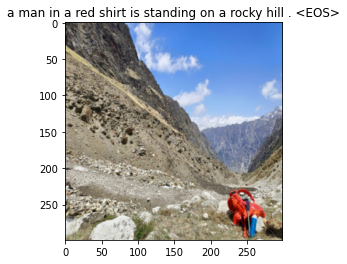

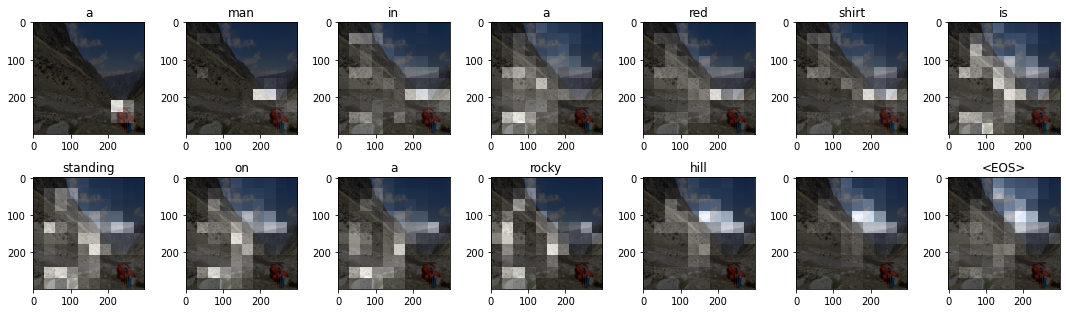

In [ ]:
img = Image.open('/content/drive/MyDrive/IMG_20190612_112537.jpg')
transform = transforms.Compose(
        [
            transforms.Resize((299, 299)),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225)),
        ]
    )
image = transform(img)
img1 = image.detach().clone()
caps,alphas = get_caps_from(image.unsqueeze(0))

plot_attention(img1, caps, alphas)

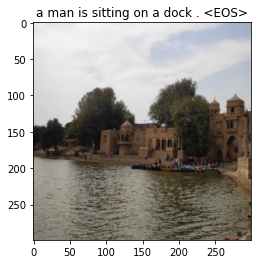

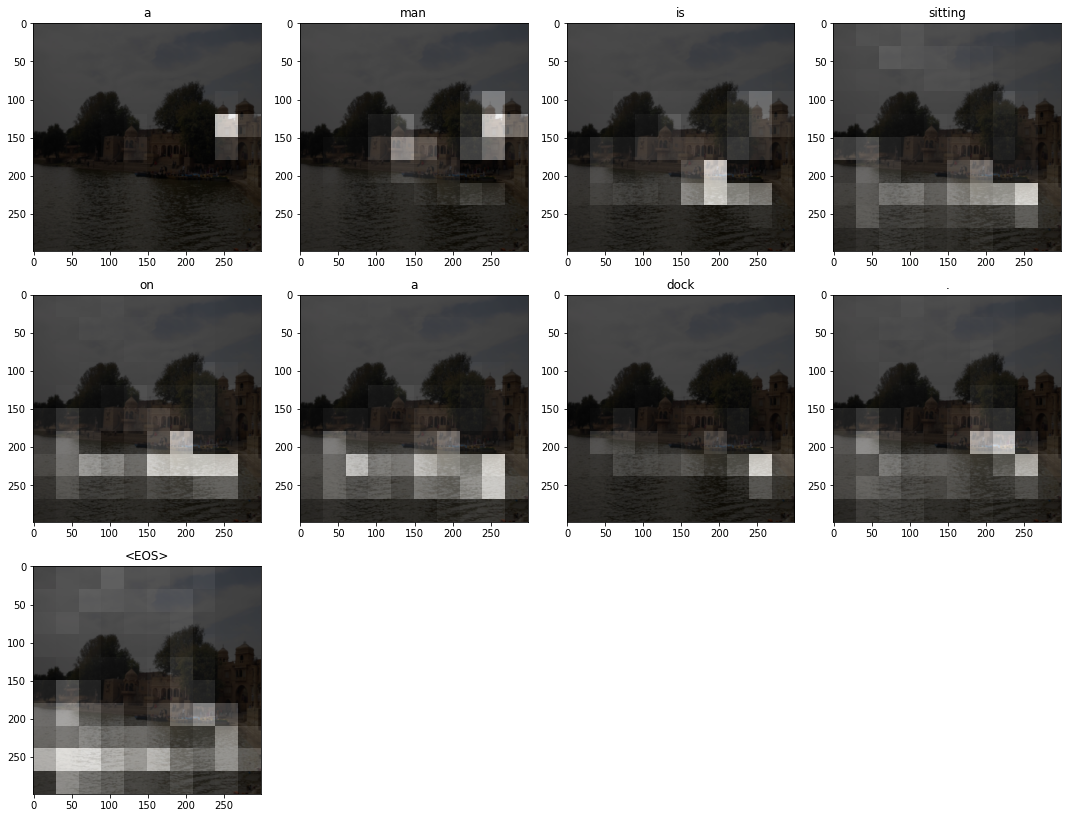

In [ ]:
img = Image.open('/content/drive/MyDrive/IMG_20190219_142633.jpg')
transform = transforms.Compose(
        [
            transforms.Resize((299, 299)),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225)),
        ]
    )
image = transform(img)
img1 = image.detach().clone()
caps,alphas = get_caps_from(image.unsqueeze(0))

plot_attention(img1, caps, alphas)

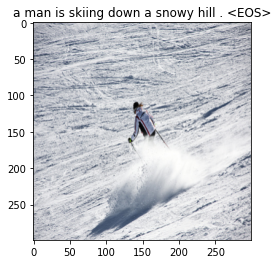

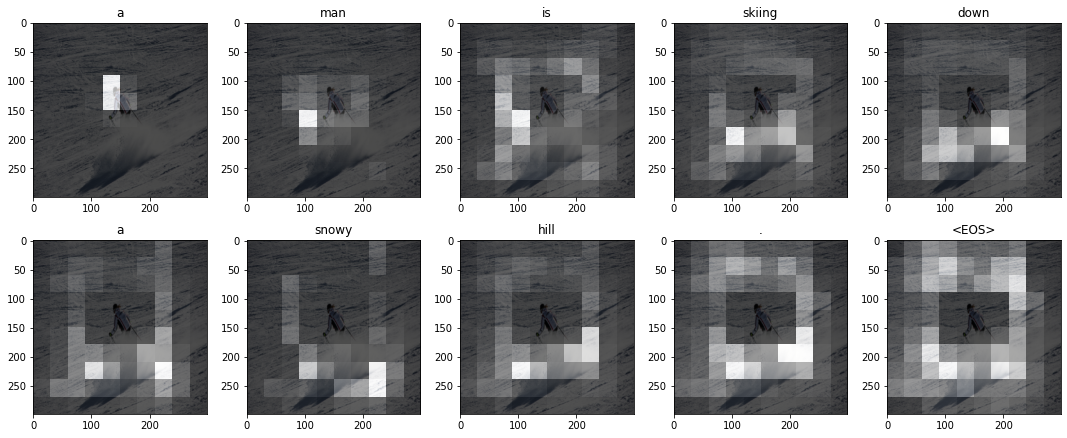

In [ ]:
dataiter = iter(test_dataloader)
images,_ = next(dataiter)

img = images[5].detach().clone()
img1 = images[5].detach().clone()
caps,alphas = get_caps_from(img.unsqueeze(0))

plot_attention(img1, caps, alphas)

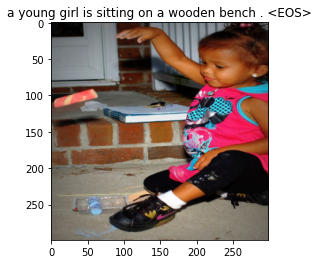

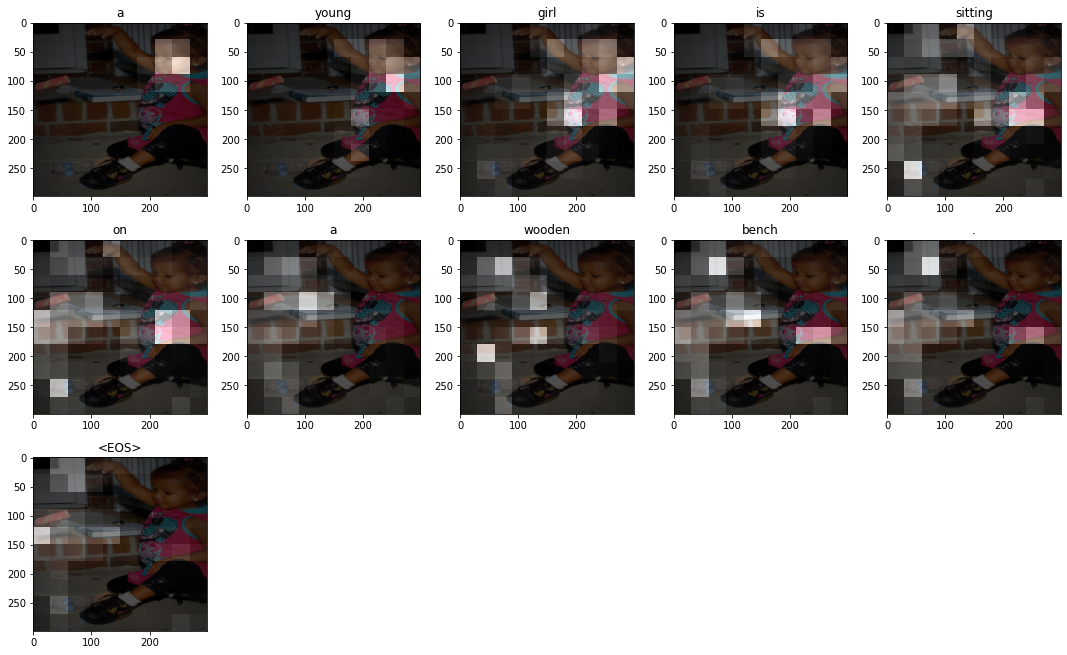

In [ ]:
dataiter = iter(test_dataloader)
images,_ = next(dataiter)

img = images[15].detach().clone()
img1 = images[15].detach().clone()
caps,alphas = get_caps_from(img.unsqueeze(0))

plot_attention(img1, caps, alphas)